# Préparation des données

### Données obenues auprès de https://world.openfoodfacts.org


### Objectif du présent document

Préparer le jeu de données en en vue de la réalisation d'une analyse univariée, bivariée et exploratoire des variables pertinentes au regard de notre proposition d'application dans le cadre d'un appel d'offre de "Santé Publique".


### Contexte de réalisation de l'étude

Notre étude du jeu de données devra être simple à comprendre pour un public néophyte. 
Nous devrons donc être particulièrement attentifs à la lisibilité et aux choix des graphiques pour illustrer notre propos.
    
### Direction de l'étude

Après une analyse univariée et bivariée du jeu de données, nous pourrons réaliser une ACP afin de comprendre les caractéristiques les plus discriminantes de notre ensemble de produits, ainsi qu'un partitionnement afin de plus simplement 
catégoriser les produits (beaucoups de catégories présentes dans le jeu).

Aussi nous pourrons effectuer quelques régressions pour étudier par exemple la correspondance entre nutriscore et nombre d'ingrédients dans un produit, la présence d'additifs ou d'allergènes.

Enfin, nous proposerons une métrique rendant compte de la qualité intrinsèque des produits, ainsi que de leur impact sur l'environnement, une métrique qui se voudra plus transparente envers le consommateur sur le bien fondé de la proposition de valeur qu'ils représentent.

### Idée d'application

Nous proposons un outil permettant au consommateur de mieux apprécier la qualité des produits qu'il consomme, et qui sera principalement basé sur l'appréciation des critères suivants :
- Le nustricore (valeur numérique)
- Le critère NOVA qui range en 4 catégories les produits en fonction de leur taux de transformation industrielle
- La présence d'addifits, d'allergènes, d'ingrédidents issus de l'huile de palme
- La disparité entre l'origine du produit, son lieu de transformation et la FRANCE
- L'appartenance du produit à un label BIO ou qui s'engage à prendre mieux soin des consommateurs
- Le type de packaging utilisé pour conditionner le produit

## Récupération des données

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import missingno as msno
import FETCH_LOAD_DATAS

In [2]:
help(FETCH_LOAD_DATAS)

Help on module FETCH_LOAD_DATAS:

NAME
    FETCH_LOAD_DATAS

DESCRIPTION
    Ce module contient la définition des variables de chemins de destination ainsi que l'importation des librairies nécessaires à la définition des 2 fonctions suivantes:
    - fetch_food_data() : qui sert à télécharger dans un sous-dossier du dossier de travail, 'datasets', le fichier .csv contenant  le jeu de données complet issu de https://fr.openfoodfacts.org/data
    - load_food_data() : qui sert à charger ce jeu de données dans un DataFrame

FUNCTIONS
    fetch_food_data(food_path='datasets', dwnld_url='https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip', zip_path='datasets\\fr.openfoodfacts.org.products.csv.zip', file_name='fr.openfoodfacts.org.products.csv')
        fonction d'extraction des données depuis https://world.openfoodfacts.org/data
    
    load_food_data(file_path='datasets\\fr.openfoodfacts.org.products.cs

## Découverte du jeu de données

In [3]:
df_food = FETCH_LOAD_DATAS.load_food_data()

C:\Users\jkomb\Desktop\Notebooks IA\+2. Projet Application Santé Publique\FETCH_LOAD_DATAS.py:36: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path, delimiter ="\t", on_bad_lines='skip')


In [4]:
df = df_food.copy()

In [5]:
df.shape

(320772, 162)

In [6]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.isna().mean().mean()

0.7622157263195134

<AxesSubplot:>

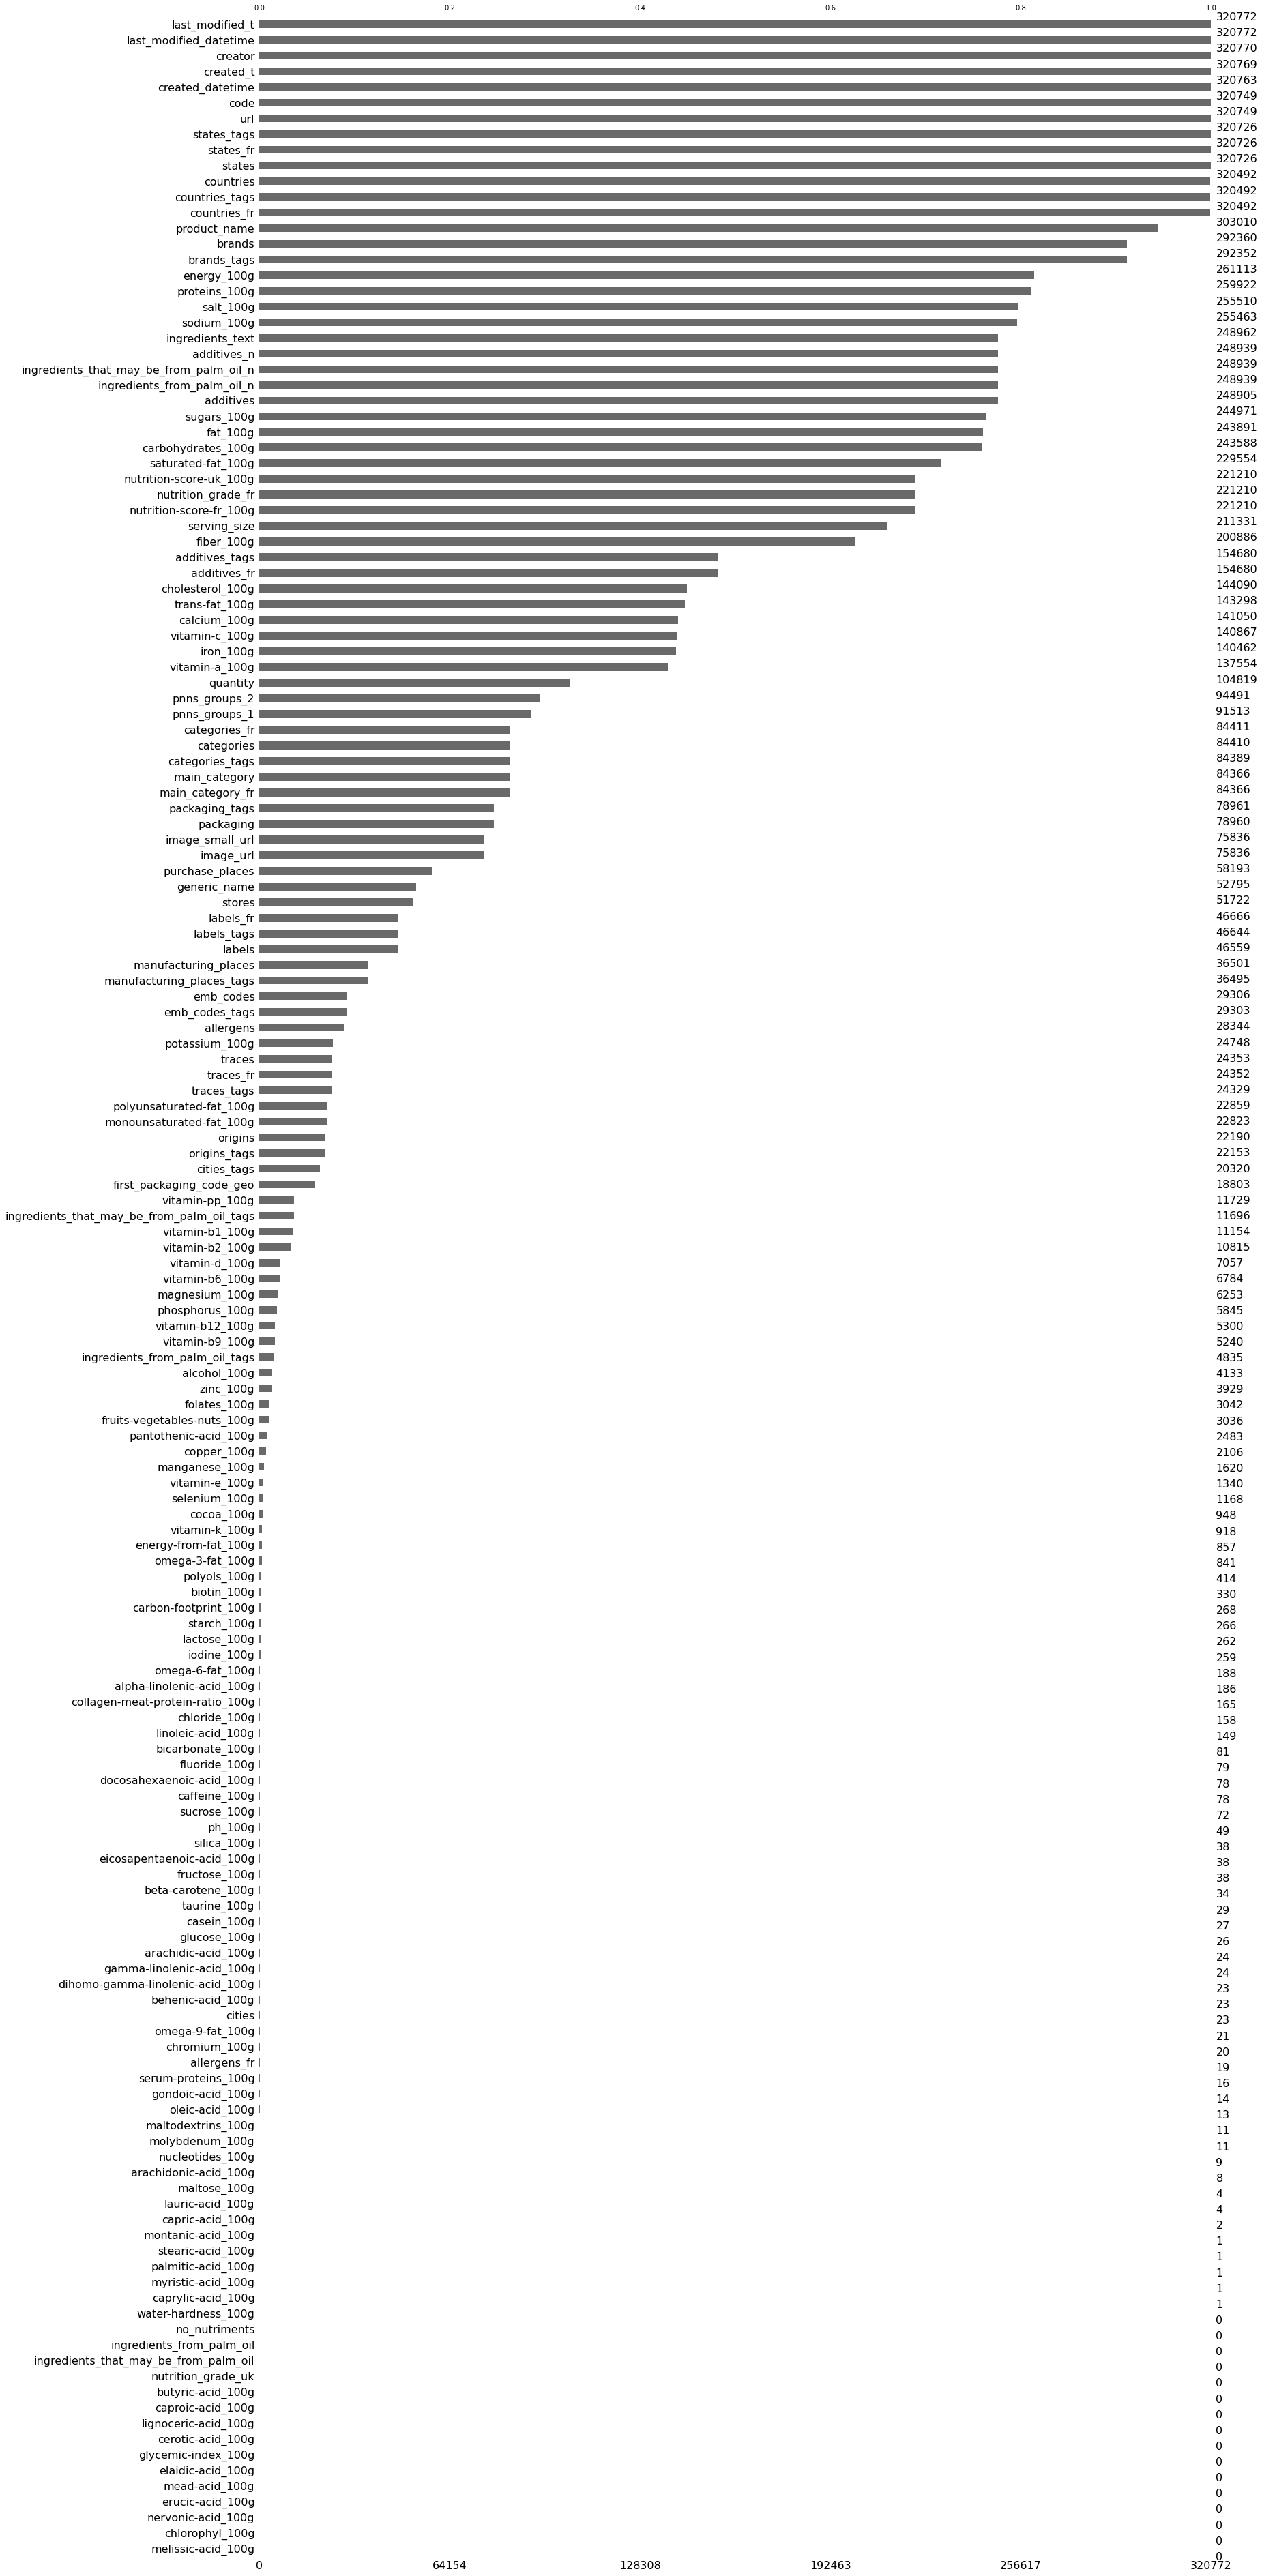

In [8]:
#trier par valeur de taux de remplissage
msno.bar(df, sort='ascending')

In [9]:
#cellule utilisée pour naviguer à traver les colonnes pour se faire une idée des valeurs qu'elles contiennent
df['traces_tags'].value_counts()[20:]

en:gluten,en:milk                                                      184
en:celery,en:mustard                                                   181
en:eggs,en:gluten,en:nuts                                              180
en:nuts,en:peanuts,en:sesame-seeds,en:soybeans                         177
en:milk,en:nuts,en:peanuts                                             171
                                                                      ... 
en:celery,en:gluten,en:sesame-seeds,en:soybeans,fr:fruitqs-a-coques      1
fr:brisures-de-noyaux                                                    1
en:gluten,en:soybeans,fr:produits-laitiers                               1
en:celery,en:gluten,en:milk,fr:produits-laitiers                         1
en:fish,en:gluten,en:molluscs,en:soybeans                                1
Name: traces_tags, Length: 3558, dtype: int64

<AxesSubplot:>

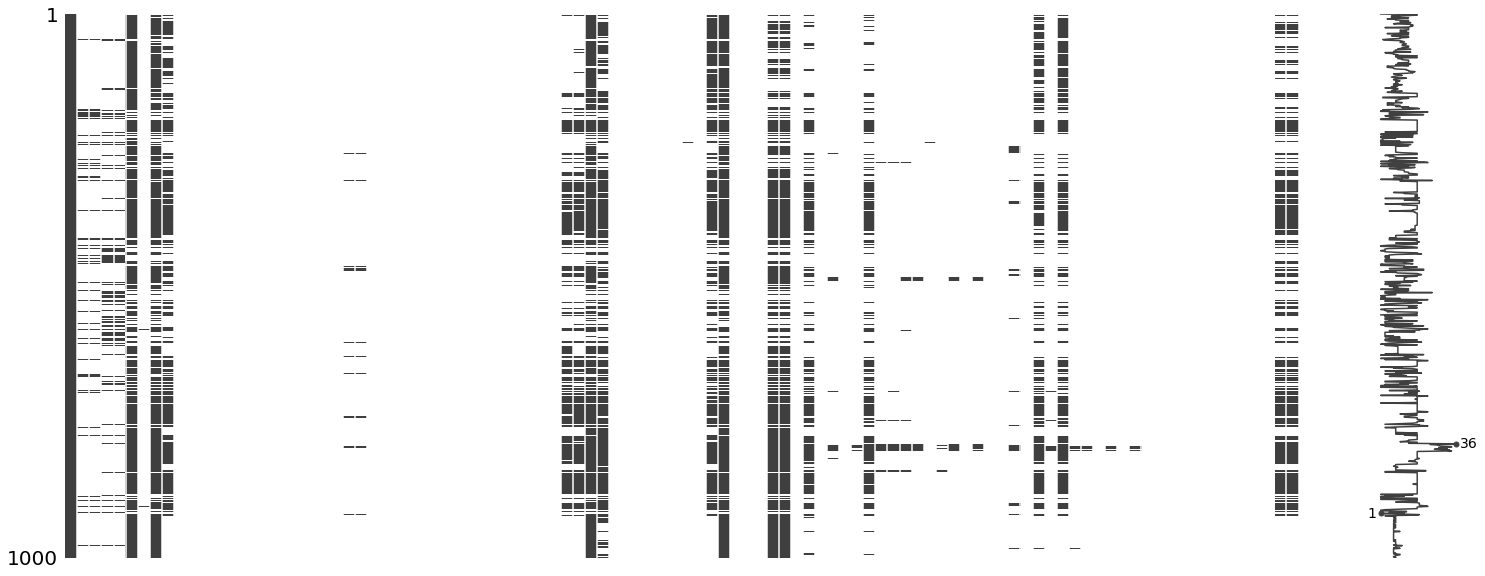

In [10]:
#cellule utilisée pour naviguer dans le jeu de données pour observer les taux de remplissage par bloc
msno.matrix(df.iloc[:1000,58:])

<AxesSubplot:>

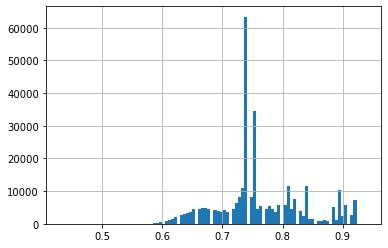

In [11]:
df.isna().mean(axis=1).hist(bins=100)

In [12]:
df.isna().mean(axis=1)[df.isna().mean(axis=1) > 0.75]

0         0.895062
1         0.765432
2         0.753086
3         0.777778
4         0.833333
            ...   
320766    0.864198
320767    0.882716
320769    0.820988
320770    0.895062
320771    0.796296
Length: 157343, dtype: float64

<AxesSubplot:>

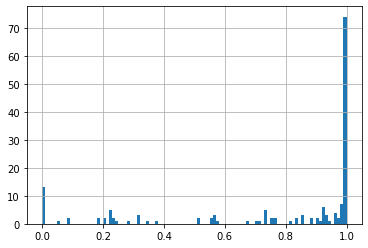

In [13]:
df.isna().mean().hist(bins=100)

In [14]:
df.isna().mean()[df.isna().mean() > 0.90]

origins                     0.930823
origins_tags                0.930938
emb_codes                   0.908639
emb_codes_tags              0.908649
first_packaging_code_geo    0.941382
                              ...   
cocoa_100g                  0.997045
chlorophyl_100g             1.000000
carbon-footprint_100g       0.999165
glycemic-index_100g         1.000000
water-hardness_100g         1.000000
Length: 100, dtype: float64

### Description du jeu de données

Le jeu de données est un ensemble de 320772 lignes et 160 colonnes qui présente un certain nombre de caractéristiques de produits alimentaires : 
- <b>générales</b> (origine, site de transformation, packaging, ingrédients, etc.)
- <b>particulières</b> (présence d'additifs, présence d'allergènes, appartenance à un label bio ou autre, etc.)
- <b>nutritionnelles</b> (taux de protéines, fibres, graisses monosaturées, vitamine b6, etc.)

Les caractéristiques de chaque produit sont réparties en <u>5 parties significatives</u> :
1. Une partie générale relative à la base de données du site https://world.openfoodfacts.org/data
2. Une partie informative contenant des métadonnées du produit (packaging, origine, lieu de transformation, etc.)
3. Une partie 'constitution du produit' avec les ingrédients, allergènes et traces d'autres produits qu'il peut contenir
4. Une partie présentant des informations diverses telles que la présence d'additifs, d'huile de palme et notamment sur le NUTRISCORE** du produit
5. Une partie nutritionnelle où l'on retrouve toutes les informations typiques d'énergie pour 100g de produit consommé, la teneur en 96 nutriments différents pour 100 g de produits ainsi que le nutriscore** du produit.

** On fait ici la différence entre le NUTRISCORE (A,B,C,D,E) et le nutriscore qui est la valeur numérique avant transformation en catégorie (A,B,C,D,E). Cette distinction sera faite dans toute la suite de notre étude.

Le jeu de données présente un taux de valeurs manquantes de <b>76%</b> :
- Près de la moitié des colonnes présentent un taux de valeurs manquantes supérieur à <b>99%</b>, mode de la distribution des  taux de valeurs manquantes des colonnes (74 colonnes)
- Plus de 60% des colonnes présentent un taux de valeurs manquantes supérieur à <b>90%</b> (100 colonnes)
- Plus de 2/3 des lignes (71%) présentent un taux de valeurs manquantes supérieur à <b>75%</b>, mode de la distribution des taux de valeurs manquantes des lignes (229030 lignes)

### Sélection des variables utiles

Pour la suite de notre étude du jeu de données, nous allons, partie par partie décortiquer les variables que nous allons garder, et selon ces colonnes, les individus dont nous allons nous séparer.

Comme il y a significativement plus valeurs pour les colonnes du début du tableau, que pour les colonnes du milieu vers la fin du tableau (à l'exception du nutriscore), nous considérons que nous pourrons épurer celui-ci de gauche à droite, de partie en partie, à quelques exceptions près de variables peut-être.

#### 1. Partie générale relative à la base de données des produits

In [15]:
col1 = list(df.columns[:df.columns.get_loc('packaging')])
col1

['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'generic_name',
 'quantity']

Nous n'allons conserver que les colonnes 'code', 'url', 'last_modified_datetime' et 'product_name'.
- Nous espérons à ce stade utiliser la colonne 'code' comme identifiant unique pour chaque produit.
- La colonne 'url' renvoie à la page produit sur le site "openfoodfacts"
- La colonne 'last_modified_datetime' pourra nous prévenir de l'ajout d'information sur un produit que nous pourrons alors peut être mieux analyser
- La colonne 'product_name' pour permettre à l'utilisateur de notre application de réaliser une recherche textuelle simple


In [16]:
col_part1_to_drop = [x for x in col1 if x not in ['code','url','last_modified_datetime','product_name' ]]
df.drop(columns=col_part1_to_drop, inplace=True)

In [17]:
df.dropna(subset=['code'],inplace=True, axis=0)

In [18]:
df[df['code'].duplicated(keep=False)].sort_values('code', ascending=True).head()

,code,url,last_modified_datetime,product_name,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
9892,11778,http://world-fr.openfoodfacts.org/produit/0011...,2017-04-02T14:13:05Z,All Butter Reduced Fat Stem Ginger Cookies,"Plastique,Sachet","plastique,sachet",Marks & Spencer,marks-spencer,"Snacks sucrés,Biscuits et gâteaux,Biscuits,Coo...","en:sugary-snacks,en:biscuits-and-cakes,en:bisc...",...,NaN,NaN,NaN,NaN,NaN,NaN,18.0,18.0,NaN,NaN
458,11778,http://world-fr.openfoodfacts.org/produit/0001...,2017-03-31T16:12:52Z,Stem Ginger Cookies,plastique,plastique,Marks & Spencer,marks-spencer,Cookies,"en:sugary-snacks,en:biscuits-and-cakes,en:bisc...",...,NaN,NaN,NaN,NaN,NaN,NaN,18.0,18.0,NaN,NaN
6,16117,http://world-fr.openfoodfacts.org/produit/0000...,2017-03-09T10:35:30Z,Organic Long Grain White Rice,NaN,NaN,Lundberg,lundberg,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
481,16117,http://world-fr.openfoodfacts.org/produit/0001...,2017-03-09T13:14:18Z,Colossal Olives With Jalapeno Peppers,NaN,NaN,Trader Joe's,trader-joe-s,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
519,24600,http://world-fr.openfoodfacts.org/produit/0002...,2015-06-27T12:03:12Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Pour les doublons, à ce stade, nous n'allons garder que l'occurence présentant le plus faible taux de valeurs manquantes.

In [19]:
df['taux_Nan'] = df.isna().mean(axis=1)
df.sort_values('taux_Nan', ascending=False, inplace=True)
df.drop_duplicates(subset=['code'], keep='first', inplace=True)
df.drop('taux_Nan', axis=1, inplace=True)

In [20]:
df.shape

(320638, 156)

In [21]:
df['code'].isna().mean()

0.0

In [22]:
df['code'].nunique()/df['code'].shape[0]

1.0

In [23]:
df_1 = df.copy()

In [24]:
df['url'].str.startswith('http').sum()

320638

La colonne 'code' peut désormais être considérée comme notre colonne identifiante pour nos données.
Le travail sur le jeu de données vis-à-vis de la partie 1 est terminée.

### RAF partie 1 :
- vérifier la validité des 'url' (https://www.moonbooks.org/Articles/Vérifier-si-une-adresse-url-existe-avec-python/)
- vérifier la validité des dates de la colonne 'last_modified_datetime'

#### 2. Partie informative contenant des métadonnées du produit

In [25]:
col2 = list(df.columns[df.columns.get_loc('packaging'):(df.columns.get_loc('countries_fr')+1)])

In [26]:
df[col2].isna().mean()

packaging                    0.753794
packaging_tags               0.753791
brands                       0.088533
brands_tags                  0.088558
categories                   0.736871
categories_tags              0.736871
categories_fr                0.736871
origins                      0.930872
origins_tags                 0.930988
manufacturing_places         0.886252
manufacturing_places_tags    0.886270
labels                       0.854814
labels_tags                  0.854549
labels_fr                    0.854549
emb_codes                    0.908604
emb_codes_tags               0.908617
first_packaging_code_geo     0.941358
cities                       1.000000
cities_tags                  0.936698
purchase_places              0.818627
stores                       0.838800
countries                    0.000873
countries_tags               0.000873
countries_fr                 0.000873
dtype: float64

In [27]:
# cellule utilisée pour explorer les différents nombres de valeurs uniques
df['categories_fr'].value_counts()

Snacks sucrés,Biscuits et gâteaux,Biscuits                                                                                                                          802
Snacks sucrés,Chocolats,Chocolats noirs                                                                                                                             609
Snacks sucrés,Confiseries,Bonbons                                                                                                                                   526
Aliments et boissons à base de végétaux,Aliments d'origine végétale,Petit-déjeuners,Céréales et pommes de terre,Céréales et dérivés,Céréales pour petit-déjeuner    522
Snacks sucrés,Biscuits et gâteaux,Biscuits,Biscuits au chocolat                                                                                                     465
                                                                                                                                                                

- Dans un premier temps, nous n'allons garder que les produits distribués en France en effectuant un tri sur la colonne 'countries_fr', puis nous allons supprimer toutes les colonnes 'countries_x'


- Ensuite, nous allons supprimer toutes les colonnes "_tags" car elles comportent les mêmes données que les colonnes auxquelles elles sont associées, mais avec une mise en forme qui les rend plus difficilement lisibles.
    

- Nous allons également supprimer les colonnes 'cities', 'cities_tags' ainsi que 'purchase_places' car nous considérons que les produits sont disponibles partout en France, ainsi que la colonne 'categories' qui est redondante avec la colonne 'categories_fr' et moins synthétique (moins de valeurs uniques pour un taux de remplissage identique).



In [28]:
#df = df_1.copy()

In [29]:
df = df[df['countries_fr'].str.contains('France', regex=False).fillna(False)]

In [30]:
L_split = [col.split('_') for col in col2]
L_tags = ['tags' in x for x in L_split]
col_part2_to_drop = [x for x,y in zip(col2, L_tags) if y]
col_part2_to_drop.append('countries')
col_part2_to_drop.append('countries_fr')
col_part2_to_drop.append('purchase_places')
col_part2_to_drop.append('cities')
col_part2_to_drop.append('categories')
df.drop(columns=col_part2_to_drop, inplace=True)

Analysons la colonne 'packaging' :

In [31]:
# pour faciliter le travail sur les chaînes de caractères, on les passe toutes en minuscule
df['packaging'] = df['packaging'].str.lower()

In [32]:
df['packaging'].value_counts()

sachet,plastique                                                                                         3872
carton                                                                                                   2599
plastique                                                                                                2561
barquette,plastique                                                                                      2120
bouteille,verre                                                                                          1630
                                                                                                         ... 
pot verre,verre,bocal                                                                                       1
plastique,boite en carton                                                                                   1
plastique,papier,aluminium                                                                                  1
barquette 

In [33]:
#cellule utilisée pour naviguer à traver les diffférentes valeurs uniques d'emballage
df['packaging'].value_counts()[50:70]

bouteille verre                             156
sachet,plastique,etui,carton                155
bocal,verre,couvercle,métal,conserve        154
boîte                                       151
frais,pot,plastique,opercule,etui,carton    150
pot                                         148
brique,carton,bouchon,plastique             140
verre,bocal                                 137
boîte,carton,plastique                      133
barquette                                   131
barquette,film,plastique                    130
carton,sachet plastique                     124
stück                                       124
verre,bouteille                             123
boite,carton                                121
bouteille,bouchon,plastique                 120
carton,barquette,plastique                  117
surgelé,carton                              116
glas                                        111
carton,carton                               109
Name: packaging, dtype: int64

In [34]:
#fonction retournant la liste contenant pour chaque valeur unique d'une colonne, la liste des sous-éléments qui la composent
def get_list_splits_str(col_name):
    return df[col_name].value_counts().index.str.split(',').tolist()

# fonction permettant de retourner la liste des sous-éléments uniques contenue dans une colonne
def get_list_uniques_splits_str(col_name):
    list_tmp = []
    list_splits = get_list_splits_str(col_name)
    for i in range(len(list_splits)):
        element = list_splits[i]
        for j in range(len(element)):
            if element[j] not in list_tmp:
                list_tmp.append(element[j])
    return list_tmp

In [35]:
L_pack_uniques = get_list_uniques_splits_str('packaging')
len(L_pack_uniques)

3251

In [36]:
L_pack_uniques

['sachet',
 'plastique',
 'carton',
 'barquette',
 'bouteille',
 'verre',
 'conserve',
 'bocal',
 'sachet plastique',
 'brique',
 'couvercle',
 'métal',
 'surgelé',
 'frais',
 'boîte',
 'pot',
 'flacon',
 'papier',
 'artikel',
 'film',
 'sous atmosphère protectrice',
 'produit',
 'opercule',
 'film plastique',
 'sous-vide',
 'aluminium',
 'canette',
 'bouteille plastique',
 'bouteille verre',
 'etui',
 'bouchon',
 'stück',
 'boite',
 'glas',
 'bocal verre',
 'couvercle métal',
 'boite carton',
 'pots',
 'sachets',
 'barquette plastique',
 'barquette et film plastique à jeter',
 'bouteille en verre',
 'kunststoff',
 'atmosphère protectrice',
 'flasche',
 'couvercle ouverture facile',
 'dose',
 'packung',
 'capsule',
 'alu recyclable',
 'plastic',
 'bois',
 'boîte métal à recycler',
 'filet',
 'tetra pak',
 'sous vide',
 'bocal en verre',
 'clip souple métal plastique',
 'karton',
 'pot plastique et opercule à jeter',
 'etui carton à recycler',
 'sachet plastique à jeter',
 'boite plasti

In [37]:
# cellule pour explorer le nombre d'occurence de mots-clés
df['packaging'].str.contains('brique').value_counts()

False    57246
True      1714
Name: packaging, dtype: int64

In [38]:
# cellule pour explorer les différentes catégories d'emballage contenant un mot-clé
df['packaging'][df['packaging'].str.contains('karton').fillna(False)].value_counts()[:10]

karton                                                                                                                                     36
karton,kunststoff                                                                                                                          11
papier,karton                                                                                                                               3
kunststoff,karton                                                                                                                           2
karton,point vert,triman,étui:carton,21 pap                                                                                                 1
paquet,carton,karton,packung                                                                                                                1
en:boîte,en:carton,en:boîte,en:pap 21,en:green dot,fr:emballage carton,de:verpackung karton,fr:recyclage carton,de:entsorgung altpapier     1
plasti

In [39]:
# cellule pour explorer les noms des produits contenant un mot-clé dans le descriptif de leur emballage
# pour mieux en appréhender le matériau
df[df['packaging']=='boîte']['product_name']

240388                   Riz Carnaroli
190871                  Lait concentré
233639                       Flageolet
191923              Mousse foie canard
195729    Taurine & Ginseng de Sibérie
                      ...             
231048                     Centrum Men
291093                      Ovomaltine
253926                     prémichèvre
291574                   Nidal Natéa 2
253920               Premilait 1er age
Name: product_name, Length: 151, dtype: object

In [40]:
L_carton = ['carto', 'papie', 'paper', 'bri', 'tetra', 'cartón', 'tétra', 'doypack', 'briquette', 'boîte à œufs', 'karton',
            'cellulose', '21', 'caton', 'papel', 'cartão', 'craton', 'cartion', 'doyapck', 'wellpappe', 'carrton',
            'boîte à oeufs', 'cardboard']

set_plastique = set(['plast', 'film', 'paquet', 'tetra', 'vide', 'protect', 'tétra', 'pet', 'doypack', 'bac', 'cellophane',
                     'blister', 'fraîcheur', 'plásti', 'sachet','pp5', 'polyprop', 'пластиковый', 'sélophane', 
                     'polyéthylène', 'plstique', 'pebd', 'poliprop', 'pvc', 'ldpe', 'pet', 'pp5', 'polystyr' , 'poliestireno',
                     'gaz', 'souple', 'céllophane', 'plastqiue', 'plastiqe', 'aérosol', 'pe-hd', '5-pp', 'pp-5', 'plastc',
                     'pp 5', '5 pp', 'pastic', 'doyapck', 'pete 1', 'pp', '5 opp','zellophan', 'atmos', 'kunststoff','filet',
                     'plasitque', 'platique', 'ficellle', 'barquette','hdpe', 'pastique', 'palstique', 'plasique', 
                     'plaqtique', 'plasitque'])

L_metal = ['alu', 'métal', 'metal', 'acier', 'conserve', 'tetra', 'tétra', 'tin', 'fût', 'can', 'konserve', 'blister',
           'fer', '40 fe', 'aérosol', 'torebki foliowej','bidon', 'bombe', 'allu', 'alimunium']

L_verre = ['verre', 'bocal', 'glas', 'glass', 'vidrio', 'vetro', 'glaß', 'verrre','vidro', 'szklana']

set_non_recyclable = set(['jeter', 'sulfurisé', 'cellophane', 'blister', 'cuisson', 'ldpe', 'non recyclable', 'céllophane',
                          'zellophan', 'filet', 'ficelle','barquette'])

L_recyclable = ['bois', 'recycle', 'recycla', 'tetra', 'tétra', 'cellulose', 'pp5', 'polyprop', 'pulpe', 'compost',
                'biodégra', 'cagette', 'pehd', 'polyéthylène', 'wood', 'pebd', 'polietile', 'pet', 'aérosol', 'pe-hd',
                'pet', 'pp', 'hdpe']

set_pack_recycl = set(['recyclé', 'consigne'])

set_no_pack = set(['sans conditionnement', 'aucun', 'vrac', 'rien', 'sans emballage'])

set_better_pack = set(['consign', 'sans suremballage', 'pefc', 'staitiegeld', 'caution', 'statiegeld', 'réutilisable',
                       'mehrwegpfand'])

set_over_pack =set(['indiv', 'suremballage', 'dose'])

L_recyclable.extend(L_carton)
L_recyclable.extend(L_metal)
L_recyclable.extend(L_verre)

set_carton = set(L_carton)
set_metal = set(L_metal)
set_verre = set(L_verre)
set_recyclable = set(L_recyclable)

dict_pack = {'carton':set_carton, 'plastique':set_plastique, 'metal':set_metal, 'verre':set_verre, 
             'non_recyclable':set_non_recyclable, 'recyclable':set_recyclable, 'pack_recycl':set_pack_recycl, 
             'pas_demballage':set_no_pack, 'emball_intell':set_better_pack, 'suremballage':set_over_pack}

In [41]:
n = 0
for value in dict_pack.values():
    n+=len(value)
n - len(L_carton)-len(L_metal)-len(L_verre)

156

Nous allons réaliser un tableau disjonctif complet où chaque produit appartiendra à autant de catégories de packaging qu'il ne contient de matières différentes ou porte une mention spécifique ('a jeter', 'recyclable').
Nous ne pouvons donc pas utiliser la fonction OneHotEncoder de scikit-learn (qui ne peut attribuer qu'une modalité à chaque individu).
Nous allons créer un ensemble de catégories de matière et mentions spécifiques, et créer une colonne pour chacune des catégories, et nous vérifierons pour chaque produit si son packaging comporte les matières ou mentions spécifiques.

Le travail préliminaire réalisé ci-avant a permis de passer de 9328 valeurs différentes, à 3251 modalités uniques puis à 156 modalités discriminant 10 catégories d'emballage (division par 61).

In [42]:
# nous définissons la fonction qui nous indiquera si le packaging d'un produit contient appartient à l'une des catégories 
# définies ci-avant

def belong_pack_catg(pack_cat, value):
    dict_cat = dict_pack[pack_cat]
    for pack in dict_cat:
        contains = str(value).__contains__(pack)
        if contains:
            n = 1
            break
        else:
            n = 0
    return n

# nous définissons ensuite la fonction qui va créer le tableau injonctif des catégories d'emballage
def set_cols_cat_allerg():
    k=1
    func = lambda value: belong_pack_catg(key, value)
    for key in dict_pack.keys():
        df.insert(loc=(df.columns.get_loc('packaging')+k), column=key, value=df['packaging'].apply(func)) 
        k+=1

In [43]:
set_cols_cat_allerg()

In [44]:
df[df['packaging'].notna()].loc[:,'carton':'suremballage']

,carton,plastique,metal,verre,non_recyclable,recyclable,pack_recycl,pas_demballage,emball_intell,suremballage
275200,0,0,0,0,0,0,0,0,0,0
283841,0,0,0,0,0,0,0,0,0,0
298974,0,0,0,0,0,0,0,0,0,0
175229,0,1,0,0,0,0,0,0,0,0
306911,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
190582,0,1,0,0,0,0,0,0,0,0
190664,0,1,0,0,0,0,0,0,0,0
253925,0,0,1,0,0,1,0,0,0,0
197594,1,0,0,0,0,1,0,0,0,0


In [48]:
(df[df['packaging'].notna()].loc[:,'carton':'suremballage'].sum(axis=1) == 0).value_counts()/df[df['packaging'].notna()].shape[0]

False    0.951509
True     0.048491
dtype: float64

In [46]:
df[df['packaging'].notna()].loc[:,'packaging'][df[df['packaging'].notna()].loc[:,'carton':'suremballage'].sum(axis=1) == 0].value_counts()[:20]

bouteille      393
surgelé        284
artikel        283
produit        256
frais          170
boîte          151
pot            148
stück          124
boite           87
flasche         66
packung         60
flacon          49
emballage       31
tube            28
tablette        27
packung(en)     26
pots            26
box             22
bottle          18
tüte            14
Name: packaging, dtype: int64

On s'aperçoit qu'avec notre tableau disjonctif, nous récupérons légèrement plus de 95% de l'information contenue dans la colonne 'packaging', le reste n'étant pas exploitable en l'état sans faire la correspondance avec le nom du produit, qui peut lui-même nous renseigner sur l'emballage utilisé.

Par ailleurs, grâce à ce dernier travail, nous pourrons facilement extraire de la valeur pour constituer la métrique de notre application.

Nous n'avons désormais plus besoin de la colonne 'packaging' :

In [49]:
df.drop('packaging', axis=1, inplace=True)

Nous allons maintenant travailler sur la colonne 'categories_fr'.
- Nous allons tâcher de synthétiser les catégories tout en ne perdant pas trop de granularité car nous nous appuierons sur les catégories de produits pour faire des recommandations dans notre application
- Nous mettrons en évidence la présence de 'viande' et de 'porc' pour les spécificités des certains régimes, la présence de 'poisson', 'fruits de mer', 'oeuf' et 'gluten' sera traitée dans la prochaine partie avec les allergènes.

In [ ]:
plt.figure(figsize=(15,8))
df['categories_fr'].value_counts()[:50].plot.bar()

In [ ]:
# pour faciliter le travail sur les chaînes de caractères, on les passe toutes en minuscule
df['categories_fr'] = df['categories_fr'].str.lower()

In [ ]:
df['categories_fr'].notna().sum()

In [ ]:
df['categories_fr'].nunique()

In [ ]:
# on crée un dictionnaire nous renseignant sur le nombre d'occurences de chaque 'sous-catégorie' 
# parmi les différentes catégories
def dict_subcateg(col_name):
    dict_tmp = {}
    L_split_subcateg = df[col_name].value_counts().index.str.split(',').tolist()
    for liste in L_split_subcateg:
        for element in liste:
            if element not in dict_tmp.keys():
                dict_tmp[element]=1
            else:
                dict_tmp[element]+=1

    dict_subcateg = {}
    sorted_keys = sorted(dict_tmp, key=dict_tmp.get, reverse=True)

    for w in sorted_keys:
        dict_subcateg[w] = dict_tmp[w]

    return dict_subcateg

dict_subcateg('categories_fr')

Les sous-catégories suivantes sont trop générales :
- 'aliments et boissons à base de végétaux'
- "aliments d'origine végétale"
- 'aliments à base de fruits et de légumes'
- 'boissons'

Nous décidons de catégoriser les produits sans elles, en créant une nouvelle colonne en retirant leur présence, et en ne sélectionnant qu'un nombre réduit de catégories pour décrire chaque produit :

In [ ]:
list_cat_to_del = ['aliments et boissons à base de végétaux', "aliments d'origine végétale",
                   'aliments à base de fruits et de légumes', 'boissons']

In [ ]:
# fonction renvoyant la chaîne de caractère 'value' raccourcie dont on a gardé les 'n_synth' premiers éléments 
# séparés par des virgules, en retirant les catégories passées en argument
def synthetize_value(value, n_synth, list_cat_to_del=list_cat_to_del):
    split_value = str(value).split(',')
    for cat in list_cat_to_del:
        split_value = [value for value in split_value if value != cat]
    synth_value = ''
    n = len(split_value)
    if n!=0:
        for i in range(np.min([n,n_synth])-1):
            synth_value += (str(split_value[i])+', ')
        synth_value += str(split_value[(np.min([n,n_synth])-1)])
    return synth_value

Pour avoir une idée de l'effet de notre catégorisation synthétique, on peut regarder combien de nouvelles modalités différentes il nous faut garder pour décrirer tous nos produits :

In [ ]:
# on trace pour chaque nombre de sous-catégories que l'on garde pour décrire un produit, l'évolution 
def display_categ_repart(n_synth, n_newmodality):
    L_plot = []
    plt.figure(figsize=(12,6))
    for i in range(n_synth+1):
        L_tmp = []
        Serie_synth_categ = df[df['categories_fr'].notna()].apply(lambda x: synthetize_value(x['categories_fr'],i), axis=1)
        for j in range(1,(n_newmodality+1)):
            L_tmp.append(Serie_synth_categ.value_counts()[:j].sum()/len(Serie_synth_categ))
        plt.plot(list(range(1,(n_newmodality+1))), L_tmp, label=f'n_synth={i}')
   
    plt.legend(bbox_to_anchor=(1,1))
    plt.grid(visible=True)
    plt.show()

In [ ]:
display_categ_repart(3,100)

On constate sans surprise, qu'en ne gardant qu'une sous-catégorie pour décrire un produit, avec seulement 20 nouvelles modalités, nous décrvions plus de 90% des produits, mais on obtient alors des catégories trop larges pour que la recommandation d'un produit appartenant à la même catégorie puisse toujours être pertinente. Il suffit de comparer les modalités les plus présentes dans le jeu de données pour 'n_synth' = 1, 2 puis 3 pour s'en apercevoir :

In [ ]:
# fonction créant la colonne catégorielle synthétique associée à la valeur de n_synth et contenant les n_synth premières
# sous-catégories de la colonne 'categories_fr' du produit
def set_col_categ_synth(n_synth):
    if 'categories_synth' in df.columns:
        df.drop('categories_synth', axis=1, inplace=True)
    Serie_categ_synth = df.apply(lambda x: synthetize_value(x['categories_fr'],n_synth), axis=1)
    df.insert(loc=(df.columns.get_loc('categories_fr')+1), column='categories_synth', value=Serie_categ_synth)

In [ ]:
set_col_categ_synth(1)
df['categories_synth'].value_counts()[:10]

In [ ]:
set_col_categ_synth(2)
df['categories_synth'].value_counts()[:10]

In [ ]:
set_col_categ_synth(3)
df['categories_synth'].value_counts()[:20]

Pour la suite de l'étude nous allons garder les colonnes obtenues pour n_synth = 2 et 3, ainsi, si nous ne trouvons pas de produits à recommander dans la catégorie d'un produit associée à n_synth = 3, nous pourrons proposer un élargissement de recommandation à la catégorie de ce produit associée à n_synth = 2 à défaut.

Pour la suite de l'étude nous allons créer 3 colonnes catégorielles chacune comportant la valeur de la sous-catégorie de niveau 0, 1 et 2 (ie. n_synth = 1, 2 et 3). Il sera alors facile de proposer des produits similaires à leur recherche nos utilisateurs finaux, et à défaut, de proposer un élargissement de recherche en proposant des produits de la même catégorie parent, ainsi de suite.. 

Par ailleurs, il sera possible d'encoder chacune des colonnes pour faciliter le traitement les traitements numériques de notre jeu de données ultérieurement !

Pour cela, nous allons modifier nos fonctions 'synthetize_value' et 'set_col_categ_synth' :

In [ ]:
# fonction retournant une liste des n_synth_max premières catégories d'un produit, en mettant la valeur 'x' si le produit
# n'est pas décrit par n_synth_max catégories
def list_synth_value(value, n_synth_max, list_cat_to_del=list_cat_to_del):
    split_value = str(value).split(',')
    for cat in list_cat_to_del:
        split_value = [value for value in split_value if value != cat]
    list_synth = []
    n=len(split_value)
    for i in range(n_synth_max):
        if i < n:
            if split_value[i] == 'nan':
                list_synth.append('x')
            else:
                list_synth.append(split_value[i])
        else:
            list_synth.append('x')
    return list_synth

In [ ]:
list_synth_value(df.loc[df[df["categories_fr"].notna()].head(1).index[0]]['categories_fr'],3)

In [ ]:
list_synth_value(df.loc[df[df["categories_fr"].isna()].head(1).index[0]]['categories_fr'],3)

In [ ]:
# fonction créant les colonnes catégorielles hiérarchiques des produits, de la catégorie la plus générale (n_synth=1) à la 
# catégorie la plus particulière (n_synth=n_synth_max)
def set_cols_categ_synth(n_synth_max):
    for i in range (n_synth_max):
        col_name = 'categories_synth{}'.format((i+1))
        if col_name in df.columns:
            df.drop(col_name, axis=1, inplace=True)
        Serie_categ_synth = df.apply(lambda x: list_synth_value(x['categories_fr'],n_synth_max)[i], axis=1)
        df.insert(loc=(df.columns.get_loc('categories_fr')+(i+1)), column=col_name, value=Serie_categ_synth)

In [ ]:
set_cols_categ_synth(3)

In [ ]:
df[df['categories_fr'].notna()].iloc[:, df.columns.get_loc('categories_fr'):df.columns.get_loc('categories_fr')+4]

Créons maintenant les colonnes nous permettant de savoir si un produit contient de la viande (pour les végétariens, végétaliens, et flexitariens) et du porc (pour ceux qui n'en consomment pas quelque soit la raison).

In [ ]:
df.insert(loc=(df.columns.get_loc('categories_synth3')+1), column='viande', value=df['categories_fr'].apply(lambda x: 1 if str(x).__contains__('viande') else 0))
df.insert(loc=(df.columns.get_loc('categories_synth3')+2), column='porc', value=df['categories_fr'].apply(lambda x: 1 if str(x).__contains__('porc') else 0))

In [ ]:
df[df['porc']==1]['viande'].value_counts()

In [ ]:
df.loc[df['porc']==1, 'viande']=1

Nous n'avons dès lors plus besoin de la colonne 'categories_fr' ni 'categories_synth'.

In [ ]:
df.drop(columns=['categories_fr','categories_synth'], axis=1, inplace=True)

In [ ]:
df_2 = df.copy()

### RAF partie 2 :
- vérifier les données aberrantes des colonnes

#### 3. Partie 'constitution du produit'

In [ ]:
df = df_2.copy()

In [ ]:
col3 = list(df.columns[df.columns.get_loc('ingredients_text'):df.columns.get_loc('serving_size')])
col3

In [ ]:
df[col3]

In [ ]:
df[col3].isna().mean()

In [ ]:
df[col3].nunique()

A ce stade nous savons que nous allons supprimer la colonne 'allergens_fr', 'traces_tags' qui nous fournit une information similaire à celle de 'traces_fr' mais en anglais et dans une mise en forme moins lisible et 'traces' qui nous fournit une information moins synthétique que 'traces_fr' (plus de valeurs uniques pour le même taux de remplissage).

Notons que les colonnes 'allergens' et 'traces_fr' contiennent le même type d'information : la présence de substances pouvant provoquer une allergie.

- Nous combinerons donc ces 2 colonnes en espérant ainsi obtenir une information plus complète.

In [ ]:
df.drop(['allergens_fr','traces_tags','traces'], axis=1, inplace=True)

In [ ]:
col3 = list(df.columns[df.columns.get_loc('ingredients_text'):df.columns.get_loc('serving_size')])
df[col3].isna().mean()

In [ ]:
# pour faciliter le travail sur les chaînes de caractères, on les passe toutes en minuscule
df['traces_fr'] = df['traces_fr'].str.lower()
df['allergens'] = df['allergens'].str.lower()

In [ ]:
L_traces = get_list_splits_str('traces_fr')
len(L_traces)

In [ ]:
L_traces

In [ ]:
L_allergens = get_list_splits_str('allergens')
len(L_allergens)

In [ ]:
L_valeurs_allerg = df['traces_fr'].value_counts().index.tolist()+df['allergens'].value_counts().index.tolist()
ens_valeurs_allerg = set(L_valeurs_allerg)
len(ens_valeurs_allerg)

In [ ]:
L_traces_uniques = get_list_uniques_splits_str('traces_fr')
len(L_traces_uniques)

In [ ]:
L_traces_uniques

In [ ]:
L_traces_reduit = ['blé', 'wheat','gluten', 'orge','cereales', 'epautre', 'cereals', 'glurent', 
                   
                   'céléri','celeria', 'czeleri', 'selleri', 'celerie', 
                   
                   'oeuf', 'œufs', 'egg', 'eggs',
                   
                   'coque', 'pistache', 'amande', 'noisette', 'noix','guscio', 'nusse', 'pistachio', 'haselnuss', 'secos', 
                   'nut', 'cashewnusse', 'pekannusse', 'amendoa', 'casca',
                   
                   'lupin', 'lupino',
                   
                   'lait','lactiques','lactosérum', 'milk', 'lactose', 'creme', 'beurre', 'laitier', 'laiit','lactoserum',
                   
                   'moutarde', 'mustard', 'mouarde', 'moutrde', 
                   
                   'poisson', 'fish','sardines','thon', 'crevettes','fisch', 'pesce', 
                   
                   'crustacés,', 'crustaces', 'surimi', 'crabe', 'crustacei', 'curstaces', 'crustacee', 
                   'crustacees', 'drustace',
                   
                   'mollusques', 'molluschi', 'jacques',
                   
                   'disulfite','sulfites', 'sulfates', 'sulfureux',
                   
                   'arachide', 'arachides', 'cacahuètes', 'cacahetes',
                   
                   'sesame', 'sésame', 'susam','cesame', 'sesamo',
                   
                   'soja', 'sija'
                    ]
len(L_traces_reduit)

In [ ]:
L_allerg_uniques = get_list_uniques_splits_str('allergens')
len(L_allerg_uniques)

In [ ]:
L_allerg_uniques

In [ ]:
L_allerg_reduit = ['comté', 'milch', 'vollmilchpulver', 'butterreinfett', 'magermilchpulver', 'fromage', 'emmental', 'lctosa',
                   'laitière', 'roquefort', 'creme', 'pecorino', 'parmigiano', 'milchzucker', 'milcheiweißhydrolysat', 'gouda',
                   'edam', 'actosérum', 'mozzarella', 'raclette', 'ricotta', 'tome', 'cheddar', 'milchschokolade', 'crème',
                   'molkenpulver', 'parmesan', 'maroilles', 'sahnepulver', 'butter', 'magermilchjoghurtpulver', 
                   'vollmilchpulver', 'leite', 'iactose', 'beaufort','yaourt', 'magermilch', 'yaourts' ,'sahnepulver', 'édam',
                   'présure', 'mascarpone', 'latte', 'feta', 'mimolette', 'laktose', 'iait', 'fromage', 'milchserum',
                   'reblochon', 'eiweißpulver', 'magermilchjoghurtpulver', 'milcheiweiß', 'magermilchkonzentrat',
                   'milchserumkonzentrat', 'whey', 'cantal', 'leche', 'lactosa', 'mantequilla', 'kuhmilch', 'weichkäse',
                   'süßmlkenpulver', 'molke', 'magermllchpulver', 'gorgonzola', 'crème', 'laitiers', 'iactosèrum', 
                   'emmenthal', 'cream', 'lactate', 'beure', 'magemilchpulver', 'bleu', 'kondensmagermilch', 'caséinate', 
                   'gouda', 'écrémé', 'schlagsahne', 'milcheiweißpulver', 'vollfett-frischkäse', 'schlagsahne', 'reblochon',
                   'ziegenmilch', 'tomme', 'laitiére', 'laitiéres', 'ialt', 'lactique', 'iactoserum', 'pecorino', 'ferments',
                   'ferment', 'lacto', 'caséinates', 'maroilles', 
                   
                   'avoine','seigle', 'épeautre', 'son', 'glutn', 'barley','gerstenmalzextrakt', 'froment', 'weizenmehl',
                   'weizenstärke', 'weizen-reis-extrudat', 'weizen-reis-extrudat', 'weizenvollkornmehl', 'segale', 'orzo',
                   'avena', 'weizeneiweiß', 'frumento', 'vollkornhaferflocken', 'volkornweizenflocken',
                   'vollkorngerstenflocken', 'cebada', 'gerste', 'weichweizenmehl', 'hartweizengrieß', 
                   'roggenmehl', 'trigo', 'gerstenflocken', 'weizen', 'gerstenmalz', 'weizenflocken', 'couscous', 
                   'gerstenmalzmehl', 'weizenmalzmehl', 'blés', 'boulghour', 'gerstenvollkornmehl', 'gerstenvollkornmehl',
                   'hafervollkornmehl', 'dinkelvollkornmehl', 'roggenvollkornmehl', 'hafervollkornflocken', 
                   'weizenvollkornflocken', 'weizenkleber', 'hartweizengrieß', 'millet', 'siegle', 'peanuts', 'malté', 
                   'weizengluten', 'amidon', 'glúten', 
                   
                   'cajou', 'pécan','pin','pignon', 'mandeln', 'pecan', 'haselnüsse', 'amandons', 'haselnussmasse', 'haselnüsse',
                   'noisettes', 'haselnuskern', 'haselnussmark', 'mandeln', 'cashewkerne', 'almendras', 'almonds', 'hazelnut',
                   'avelãs', 'cashews', 'amendes', 'nuts'
                   
                   
                   'cabillaud', 'saumon', 'maquereau', 'colin', 'brochet', 'écrevisses', 'limande','poissons', 'truite', 'lieu',
                   'anchois', 'homard', 'maquereaux', 'langoustines', 'morue', 'esturgeon', 'mer', 'merlu', 'gambas', 'merlan',
                   'bar', 'rouget', 'barbet', 'langoustine', 'harengs', 'hareng', 'sardine', 
                   
                   'huitre', 'clams', 'coquillages', 'huître', 'tourteau', 'crustace', 'moule', 'bulots', 
                   
                   'pulpe', 'poulpe', 'encornet', 'calamars', 'calmars', 'seiche', 'encornets', 'seiches', 
                   
                   'soybeans', 'lécithine', 'lecithin', 'sojalecithin', 'sojakerne', 'sojalecithine', 'soia', 
                   'lécithine de soja', 'sojasoßenpulver', 'sojabohnen', 'tofu', 'mungo', 'soya', 'soy',
                   
                   'hühnerei-trockeneiweiß','uovo', 'hühnervolleipulver', 'hühnerei', 'eigelb', 'huevo',
                   
                   'sesamöl',
                   
                   'senf', 'moutard', 
                   
                   'schwefeldioxid', 'sulfates','sulfito',
                   
                   'cacahouètes', 'erdnüsse', 'cacahuète', 
                   
                   'céleris', 'țelină'
                  ]
len(L_allerg_reduit)

In [ ]:
ens_allerg_uniques = set(L_traces_uniques)
for element in L_allerg_uniques:
    ens_allerg_uniques.add(element)
len(ens_allerg_uniques)

In [ ]:
ens_allerg_reduit = set(L_traces_reduit)
for element in L_allerg_reduit:
    ens_allerg_reduit.add(element)
len(ens_allerg_reduit)

Nous allons réaliser un tableau disjonctif complet où chaque produit appartiendra à autant de catégories d'allergènes qu'il en contient. Nous ne pouvons donc pas utiliser la fonction OneHotEncoder de scikit-learn (qui ne peut attribuer qu'une modalité à chaque individu).
Nous allons créer un ensemble de susbstances allergènes par catégorie (14 en tout), et créer une colonne pour chacune des catégories, et nous vérifierons pour chaque produit la présence de substances de la catégorie dans son champ 'allergens' et 'traces_fr'.

Le travail préliminaire réalisé ci-avant a permis de passer de 11788 valeurs différentes, à 1879 modalités uniques puis à 309 modalités discriminant 14 catégories de substances allergènes (division par 38).

NB : le tri des "mots-clés" des listes de modalités uniques pour obtenir les listes réduites a été réalisé à la main, et bien que l'opération ait été réalisée minutieusement, il y aura des manques que nous considérons comme étant des erreurs de perte d'information inhérentes au processus de transformation que nous avons choisi.
- Une autre manière de procéder aurait été de lister l'ensemble des substances les plus courantes appartenant aux 14 catégories d'allergènes qu'il est obligatoire de mentionner sur l'emballage d'un produit, et de les traduire dans toutes les langues de l'union européenne, mais cela aurait donné un tableau trop volumineux et nous n'aurions pas pu capter les mots-clés relevant de fautes d'orthographes, les variations de mots avec ou sans accent, ainsi que les mots au pluriel comme nous avons pu le faire ici.

In [ ]:
set_gluten = set(['gluten', 'glurent', 'glutn', 'glúten'
    
])

set_oeuf = set(['hühnerei-trockeneiweiß','uovo', 'hühnervolleipulver', 'hühnerei', 'eigelb', 'huevo', 'oeuf', 'œufs', 'egg',
                'eggs'])

set_fruits_coque = set(['coque', 'pistache', 'amande', 'noisette', 'noix','guscio', 'nusse', 'pistachio', 'haselnuss', 'secos', 
                   'nut', 'cashewnusse', 'pekannusse', 'amendoa', 'casca', 'cajou', 'pécan','pin','pignon', 'mandeln', 'pecan', 
                   'haselnüsse', 'amandons', 'haselnussmasse', 'haselnüsse','noisettes', 'haselnuskern', 'haselnussmark',
                   'mandeln', 'cashewkerne', 'almendras', 'almonds', 'hazelnut', 'avelãs', 'cashews', 'amendes', 'nuts'])

set_lupin = set(['lupin', 'lupino'])

set_lait = set(['lait','lactiques','lactosérum', 'milk', 'lactose', 'creme', 'beurre', 'laitier', 'laiit','lactoserum',
                'comté', 'milch', 'vollmilchpulver', 'butterreinfett', 'magermilchpulver', 'fromage', 'emmental', 'lctosa',
                'laitière', 'roquefort', 'creme', 'pecorino', 'parmigiano', 'milchzucker', 'milcheiweißhydrolysat', 'gouda',
                'edam', 'actosérum', 'mozzarella', 'raclette', 'ricotta', 'tome', 'cheddar', 'milchschokolade', 'crème',
                'molkenpulver', 'parmesan', 'maroilles', 'sahnepulver', 'butter', 'magermilchjoghurtpulver', 
                'vollmilchpulver', 'leite', 'iactose', 'beaufort','yaourt', 'magermilch', 'yaourts' ,'sahnepulver', 'édam',
                'présure', 'mascarpone', 'latte', 'feta', 'mimolette', 'laktose', 'iait', 'fromage', 'milchserum',
                'reblochon', 'eiweißpulver', 'magermilchjoghurtpulver', 'milcheiweiß', 'magermilchkonzentrat',
                'milchserumkonzentrat', 'whey', 'cantal', 'leche', 'lactosa', 'mantequilla', 'kuhmilch', 'weichkäse',
                'süßmlkenpulver', 'molke', 'magermllchpulver', 'gorgonzola', 'crème', 'laitiers', 'iactosèrum', 
                'emmenthal', 'cream', 'lactate', 'beure', 'magemilchpulver', 'bleu', 'kondensmagermilch', 'caséinate', 
                'gouda', 'écrémé', 'schlagsahne', 'milcheiweißpulver', 'vollfett-frischkäse', 'schlagsahne', 'reblochon',
                'ziegenmilch', 'tomme', 'laitiére', 'laitiéres', 'ialt', 'lactique', 'iactoserum', 'pecorino', 'ferments',
                'ferment', 'lacto', 'caséinates', 'maroilles'])

set_sulfites = set(['schwefeldioxid', 'sulfates','sulfito', 'disulfite','sulfites', 'sulfates', 'sulfureux'])

set_poissons = set(['poisson', 'fish','sardines','thon', 'crevettes','fisch', 'pesce','cabillaud', 'saumon', 'maquereau', 
                    'colin', 'brochet', 'écrevisses', 'limande','poissons', 'truite', 'lieu', 'anchois', 'homard',
                    'maquereaux', 'langoustines', 'morue', 'esturgeon', 'mer', 'merlu', 'gambas', 'merlan', 'bar', 'rouget',
                    'barbet', 'langoustine', 'harengs', 'hareng', 'sardine'])

set_mollusques = set(['mollusques', 'molluschi', 'jacques','pulpe', 'poulpe', 'encornet', 'calamars', 'calmars', 'seiche', 
                      'encornets', 'seiches'])

set_crustaces = set(['crustacés,', 'crustaces', 'surimi', 'crabe', 'crustacei', 'curstaces', 'crustacee', 
                     'crustacees', 'drustace','huitre', 'clams', 'coquillages', 'huître', 'tourteau', 'crustace',
                     'moule', 'bulots'])

set_soja = set(['soybeans', 'lécithine', 'lecithin', 'sojalecithin', 'sojakerne', 'sojalecithine', 'soia', 'lécithine de soja',
                'sojasoßenpulver', 'sojabohnen', 'tofu', 'mungo', 'soya', 'soy','soja', 'sija'])

set_cereales = set(['blé', 'wheat','gluten', 'orge','cereales', 'epautre', 'cereals', 'glurent', 'avoine','seigle', 
                    'épeautre', 'son', 'glutn', 'barley','gerstenmalzextrakt', 'froment', 'weizenmehl', 'weizenstärke',
                    'weizen-reis-extrudat', 'weizen-reis-extrudat', 'weizenvollkornmehl', 'segale', 'orzo', 'avena', 
                    'weizeneiweiß', 'frumento', 'vollkornhaferflocken', 'volkornweizenflocken', 'vollkorngerstenflocken',
                    'cebada', 'gerste', 'weichweizenmehl', 'hartweizengrieß', 'roggenmehl', 'trigo', 'gerstenflocken',
                    'weizen', 'gerstenmalz', 'weizenflocken', 'couscous', 'gerstenmalzmehl', 'weizenmalzmehl', 'blés',
                    'boulghour', 'gerstenvollkornmehl', 'gerstenvollkornmehl', 'hafervollkornmehl', 'dinkelvollkornmehl',
                    'roggenvollkornmehl', 'hafervollkornflocken', 'weizenvollkornflocken', 'weizenkleber', 'hartweizengrieß',
                    'millet', 'siegle', 'malté', 'weizengluten', 'amidon', 'glúten'])

set_arachides = set(['arachide', 'arachides', 'cacahuètes', 'cacahetes','cacahouètes', 'erdnüsse', 'cacahuète', 'peanuts'])

set_celeri = set(['céléri','celeria', 'czeleri', 'selleri', 'celerie', 'céleris', 'țelină'])

set_sesame = set(['sesame', 'sésame', 'susam','cesame', 'sesamo', 'sesamöl'])

set_moutarde = set(['moutarde', 'mustard', 'mouarde', 'moutrde','senf', 'moutard'])

dict_allerg = {'gluten': set_gluten, 'oeuf':set_oeuf, 'fruits_coque':set_fruits_coque, 'lupin':set_lupin, 'lait':set_lait, 
               'sulfites':set_sulfites, 'poissons':set_poissons, 'mollusques':set_mollusques, 'crustaces':set_crustaces, 
               'soja':set_soja, 'cereales':set_cereales, 'arachides':set_arachides, 'celeri':set_celeri, 'sesame':set_sesame, 
               'moutarde':set_moutarde}

In [ ]:
for key in dict_allerg.keys():
    print(key)

In [ ]:
len(dict_allerg.keys())

In [ ]:
for substance in dict_allerg['oeuf']:
    print(substance)

In [ ]:
df.insert(loc=(df.columns.get_loc('traces_fr')+1), column='substances_allergenes', value=(df['traces_fr'] + ',' + df['allergens']))

In [ ]:
df['substances_allergenes'].fillna('inconnues', inplace=True)

In [ ]:
df['substances_allergenes']

In [ ]:
df['substances_allergenes'][253925].__contains__('lactose')

Nous constatons ici que nous aurions pu travailler sur la colonne issue de la jointure des colonnes 'traces_fr' et 'allergenes' car elle présente un nombre de valeurs uniques plus petit que la jointure des listes de valeurs uniques de ces mêmes colonnes (8367 contre 11788).

In [ ]:
# nous définissons la fonction qui nous indiquera si un produit contient une substance de la catégorie passée en argument
def contains_allerg(cat_allerg, value):
    dict_cat = dict_allerg[cat_allerg]
    for substance in dict_cat:
        contains = value.__contains__(substance)
        if contains:
            n = 1
            break
        else:
            n = 0
    return n

In [ ]:
def set_cols_cat_allerg():
    k=1
    func = lambda value: contains_allerg(key, value)
    for key in dict_allerg.keys():
        df.insert(loc=(df.columns.get_loc('traces_fr')+k), column=key, value=df['substances_allergenes'].apply(func)) 
        k+=1

In [ ]:
set_cols_cat_allerg()

In [ ]:
df[df['substances_allergenes'] != 'inconnues'].loc[:,'oeuf':'moutarde']

In [ ]:
df['soja'].sum()

In [ ]:
df.shape

In [ ]:
(df[df['substances_allergenes'] != 'inconnues'].loc[:,'oeuf':'moutarde'].sum(axis=1) == 0).value_counts()

Nous avons perdu l'information de présence d'allergènes pour uniquement 7 produits sur la totalité (0.06%).
Nous traitons ces produits réticents à la main.

In [ ]:
df[df['substances_allergenes'] != 'inconnues'][df[df['substances_allergenes'] != 'inconnues'].loc[:,'oeuf':'moutarde'].sum(axis=1) == 0]['substances_allergenes']

Nous ajoutons la valeur 'céleri' à notre ensemble 'set_celeri'.

In [ ]:
set_celeri.clear()
set_celeri = set_celeri = set(['céléri','celeria', 'czeleri', 'selleri', 'celerie', 'céleris', 'țelină', 'céleri'])
dict_allerg = {'oeuf':set_oeuf, 'fruits_coque':set_fruits_coque, 'lupin':set_lupin, 'lait':set_lait, 'sulfites':set_sulfites,
               'poissons':set_poissons, 'mollusques':set_mollusques, 'crustaces':set_crustaces, 'soja':set_soja,
               'cereales':set_cereales, 'arachides':set_arachides, 'celeri':set_celeri, 'sesame':set_sesame, 
               'moutarde':set_moutarde}

In [ ]:
df['celeri'] = df['substances_allergenes'].apply(lambda value: contains_allerg('celeri', value))

In [ ]:
(df[df['substances_allergenes'] != 'inconnues'].loc[:,'oeuf':'moutarde'].sum(axis=1) == 0).value_counts()

On retrouve notre ligne mentionnant du 'réglisse' qui n'est pas une substance allergène à mentionner obligatoirement par le fabricant. Nous n'avons désormais plus besoin des colonnes 'traces_fr' et 'allergens'.

In [ ]:
df.drop(['traces_fr','allergens'], axis=1, inplace=True)

In [ ]:
df.shape

In [ ]:
df_3 = df.copy()

#### 4. Partie 'informations diverses'

In [ ]:
col4 = list(df.columns[df.columns.get_loc('serving_size'):df.columns.get_loc('energy_100g')])
col4

In [ ]:
df[col4].isna().mean()

In [ ]:
#cellule utilisée pour explorer les différentes valeurs des colonnes
df['no_nutriments'].value_counts()[:15]

Nous n'allons conserver que les colonnes suivantes :
- 'additives_n' : qui nous renseigne sur le nombre d'additifs présents dans le produit
- 'additives_fr' : qui nous renseignent sur les additifs présents (pour évaluer leur dangerosité)
- 'ingredients_from_palm_oil_n' : qui nous renseigne sur le nombre d'ingrédients issus de l'huile de palme, présents dans le produit
- 'ingredients_that_may_be_from_palm_oil_n' : qui nous renseigne sur le nombre d'ingrédients peut-être issus de l'huile de palme, présents dans le produit
- 'nutrition_grade_fr' : qui nous renseigne sur le NUTRISCORE du produit
- 'image_small_url' : qui nous fournit l'url de l'image du produit que l'on pourra afficher dans notre application

Les autres colonnes sont soit vides, soit nous donnent une informations que nous n'allons pas exploiter, ou bien sont moins compréhensible ou synthétique.

In [ ]:
col_part4_to_drop = col4
col_part4_to_drop.remove('additives_n')
col_part4_to_drop.remove('additives_fr')
col_part4_to_drop.remove('ingredients_from_palm_oil_n')
col_part4_to_drop.remove('ingredients_that_may_be_from_palm_oil_n')
col_part4_to_drop.remove('nutrition_grade_fr')
col_part4_to_drop.remove('image_small_url')
df.drop(columns=col_part4_to_drop, inplace=True)

In [ ]:
col4 = list(df.columns[df.columns.get_loc('additives_n'):df.columns.get_loc('energy_100g')])
df[col4].head()

In [ ]:
df[col4].isna().mean()

In [ ]:
df_4 = df.copy()

#### 5. Partie informations nutritionnelles

In [ ]:
col5 = list(df.columns[df.columns.get_loc('energy_100g'):])
col5

In [ ]:
len(col5)

In [ ]:
msno.bar(df[col5], sort='descending')

In [ ]:
nom_produit = 'Gnocchi'
df.loc[df['product_name'].str.contains(nom_produit).fillna(False)]

In [ ]:
df.head()

In [ ]:
df.iloc[53100][:15]